In [20]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [14]:
from typing import Tuple, Dict
import optuna
import pandas as pd
import os
from pathlib import Path


from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [21]:
base_dir = Path().resolve()  
data_dir = base_dir 

file_path_train = data_dir / "train.csv"
file_path_test = data_dir / "test.csv"

train_df = pd.read_csv(file_path_train)
test_df = pd.read_csv(file_path_test)


print(test_df.head())

              id AP     creation_date_answer  situation  ctc  location  gc_id  \
0  cb7a4e0dd0777  f  2019-03-13 07:00:52.562         30  NaN       100     40   
1  e78e3915f3e30  f  2019-01-07 13:45:55.741         -1    f        95     40   
2  8e65ba155f983  f  2019-01-25 14:01:07.041         -1    f        34     20   
3  701e90ca03ce2  f  2019-01-16 14:35:11.432         10    f        45     40   
4  768fefec8609a  f  2019-02-11 14:25:37.331         10    f        95    100   

  gc_label     creation_date_global       id_group  ... fruit_situation_label  \
0        B  2019-03-13 07:03:13.632  b6a3d931cbbaf  ...                   jzy   
1        B  2018-12-18 18:28:41.942  1b35749232404  ...                  hetz   
2        D  2018-01-17 13:12:05.124  8f7612ff2c9cc  ...                    ag   
3        B  2018-11-07 13:21:33.877  2e3620e03b5f3  ...                    ag   
4        H  2018-10-16 10:17:01.716  ac19c1e8abd0d  ...                  hetz   

  fruits_or_vegetables  nu

### Preprocessing

1.  **Categorical Variables**:

    *   I applied **One Hot Encoding** for categorical columns with a small number of modalities.

    *   categorical\_columns : \[ 'AP', 'ctc', 'gc\_label', 'favorite\_fruit', 'fruit\_situation\_label', 'fruits\_or\_vegetables', 'hobby', 'green\_vegetables', 'vegetable\_type'\]
        
    
            
2.  **Quantitative Variables**:
    
    *   I identified quantitative columns with a small number of possible values, which might contain either large or small numeric values, both positive and negative.

    *   For categorical columns with a large number of unique values (such as 'ville'), I applied **Frequency Encoding**. This involves encoding the values based on the frequency of their occurrences, i.e., the ratio of occurrences of a specific category divided by the total occurrences of all categories, and normalized the values between 0 and 1 to ensure consistent scaling across all features.
        
    *   columns\_to\_check : \['situation', 'location', 'gc\_id', 'fruit\_situation\_id', 'number\_of\_fruit'\] + \['ville'\]
        

        
3.  **Date Columns**:
    
    *   After extracting these components, I applied **Frequency Encoding** to each of the newly created columns (i.e., year, month, and day) to encode the temporal information.

     *   date\_columns : \['creation\_date\_answer', 'creation\_date\_global', 'creation\_date\_request'\]
        


4.  **Id Columns**:
    
    *   id\_columns : \['id\_group', 'id\_group\_2', 'id\_group\_3', 'id\_group\_4'\]
        
    *   These columns had a large number of unique values, with approximately 15,000 unique IDs for some, making them likely not very informative for model training. Therefore, I decided to **drop** these columns, assuming they did not provide significant value.
        
5.  **Columns to Remove**:
    
    *   columns\_to\_remove : \[ 'creation\_date\_answer', 'creation\_date\_global', 'id\_group', 'id\_group\_2', 'id\_group\_3', 'creation\_date\_request', 'id\_group\_4'\]
        
6.  **Final Design Matrix**:
    
    *   I replace in the end all missing values by 0. After encoding all the variables into real numbers between 0 and 1, I had the final **design matrix** ready for model training, with the **'id'** column retained to preserve the identity of each observation.

In [22]:
class DummyEncoder(BaseEstimator, TransformerMixin):
    """
    Dummy Encoder for performing One-Hot Encoding on categorical columns,
    Frequency Encoding on 'ville', numeric columns, and date-related columns,
    and dropping specific columns. Also, extracts date components for specific date columns.
    """

    def __init__(self, categorial_columns: list = None,
                 columns_to_drop: list = None, 
                 columns_to_check: list = None,
                 date_columns: list = None):
        """
        Initializes the DummyEncoder.

        Parameters:
        categorial_columns : list, optional
            List of categorical column names to encode (except 'ville').
        columns_to_drop : list, optional
            List of column names to drop.
        columns_to_check : list, optional
            List of columns to apply frequency encoding to (including 'ville').
        date_columns : list, optional
            List of date columns to extract year, month, and day components.
        """
        self.categorial_columns = categorial_columns
        self.columns_to_drop = columns_to_drop if columns_to_drop is not None else []
        self.columns_to_check = columns_to_check if columns_to_check is not None else []
        self.date_columns = date_columns if date_columns is not None else []

    def fit(self, X: pd.DataFrame, y: np.ndarray = None) -> 'DummyEncoder':
        """
        Fits the encoder to the input data, learning the unique categories for each categorical column.

        Parameters:
        X : pandas DataFrame
            The input data to fit the encoder on.
        y : None
            Not used, but required for compatibility with scikit-learn API.

        Returns:
        self : returns an instance of self.
        """
        self.unique_categories_ = {}
        if self.categorial_columns is None:
            self.categorial_columns = X.select_dtypes(include=['object', 'category']).columns
        for col in self.categorial_columns:
            self.unique_categories_[col] = X[col].dropna().unique()
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transforms the input data by applying One-Hot Encoding to the categorical columns,
        Frequency Encoding to 'ville' and numeric columns, and dropping specific columns.

        Parameters:
        X : pandas DataFrame
            The input data to transform.

        Returns:
        X_transformed : pandas DataFrame
            The transformed data with encoded columns and specific columns dropped.
        """
        X_transformed = X.copy()
        X_transformed = self.extract_date_components(X_transformed)
        
        # Drop specified columns
        X_transformed = self.drop_columns(X_transformed)
        
        # Frequency encoding for specific columns including date components
        for col in self.columns_to_check + ['ville'] + [col + '_year' for col in self.date_columns] + \
            [col + '_month' for col in self.date_columns] + [col + '_day' for col in self.date_columns]:
            if col in X_transformed:
                X_transformed = self.encode_by_frequency(X_transformed, col)
        
        # One-Hot Encoding for categorical columns
        for col in self.unique_categories_.keys():
            if col in X_transformed:
                X_transformed = self.encode_by_onehot(X_transformed, col)
        
        # Replace NaN with 0 and boolean values with 0/1
        X_transformed.fillna(0, inplace=True)
        X_transformed = X_transformed.replace({True: 1, False: 0})
        
        return X_transformed

    def encode_by_frequency(self, X: pd.DataFrame, column: str) -> pd.DataFrame:
        """
        Encodes a categorical or numeric column by the frequency of each category or value.

        Parameters:
        X : pandas DataFrame
            The input data.
        column : str
            The column to be encoded.

        Returns:
        X : pandas DataFrame
            The data with the frequency-encoded column.
        """
        if column in X.columns:
            freq_encoding = X[column].value_counts(normalize=True)
            X[column + '_encoded'] = X[column].map(freq_encoding)
            X = X.drop(columns=[column])
        return X

    def encode_by_onehot(self, X: pd.DataFrame, column: str) -> pd.DataFrame:
        """
        Encodes a categorical column by One-Hot Encoding.

        Parameters:
        X : pandas DataFrame
            The input data.
        column : str
            The column to be encoded.

        Returns:
        X : pandas DataFrame
            The data with One-Hot encoded column.
        """
        if column in X.columns:
            dummies = pd.get_dummies(X[column], prefix=column)
            X = X.drop(columns=[column])
            X = pd.concat([X, dummies], axis=1)
        return X

    def drop_columns(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Drops specific columns from the DataFrame.

        Parameters:
        X : pandas DataFrame
            The input data containing columns to be dropped.

        Returns:
        X : pandas DataFrame
            The input data with specific columns removed.
        """
        X = X.drop(columns=self.columns_to_drop, errors='ignore')
        return X
    
    def extract_date_components(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Extracts year, month, and day from specified date columns and creates new columns.
        
        Parameters:
        df : pandas DataFrame
            The DataFrame with date columns.
        
        Returns:
        df : pandas DataFrame
            The DataFrame with new year, month, and day columns for each specified date column.
        """
        for col in self.date_columns:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce')
                
                if df[col].isnull().all():
                    print(f"Warning: Column {col} could not be converted to datetime.")
                    continue

                df[col + '_year'] = df[col].dt.year
                df[col + '_month'] = df[col].dt.month
                df[col + '_day'] = df[col].dt.day
        return df


columns_to_remove = [
    'creation_date_answer', 'creation_date_global', 'id_group', 
    'id_group_2', 'id_group_3', 'creation_date_request', 'id_group_4'
]
columns_to_check = ['situation', 'location', 'gc_id', 'fruit_situation_id', 'number_of_fruit']
date_columns = ['creation_date_answer', 'creation_date_global', 'creation_date_request']

# Initialize the DummyEncoder
encoder = DummyEncoder(
    categorial_columns=[
        'AP', 'ctc', 'gc_label', 'favorite_fruit', 'fruit_situation_label', 
        'fruits_or_vegetables', 'hobby', 'green_vegetables', 'vegetable_type'
    ], 
    columns_to_drop=columns_to_remove,
    columns_to_check=columns_to_check,
    date_columns=date_columns  
)

# Prepare and encode the data
df_train = train_df.copy()
df_train.columns = df_train.columns.str.strip()  
df_encoded_train = encoder.fit_transform(df_train)

# Save the final encoded dataframe with the new date columns
file_path_dir = data_dir / "design_matrix.csv"
df_encoded_train.to_csv(file_path_dir, index=False)

print(df_encoded_train.head())


              id  target  situation_encoded  location_encoded  gc_id_encoded  \
0  a46cfa61ea20a       0             0.9586           0.00908        0.02100   
1  c3d0cb8f0c5e2       1             0.9586           0.01876        0.55252   
2  05dfbe0ec3a8b       0             0.9586           0.04980        0.55252   
3  952e869ee1076       1             0.9586           0.01848        0.55252   
4  5bd0e71b1395b       1             0.9586           0.01016        0.15416   

   fruit_situation_id_encoded  number_of_fruit_encoded  ville_encoded  \
0                     0.03732                  0.71672            0.0   
1                     0.28764                  0.71672            0.0   
2                     0.42604                  0.71672            0.0   
3                     0.28764                  0.21260            0.0   
4                     0.28764                  0.71672            0.0   

   creation_date_answer_year_encoded  creation_date_global_year_encoded  ...  \


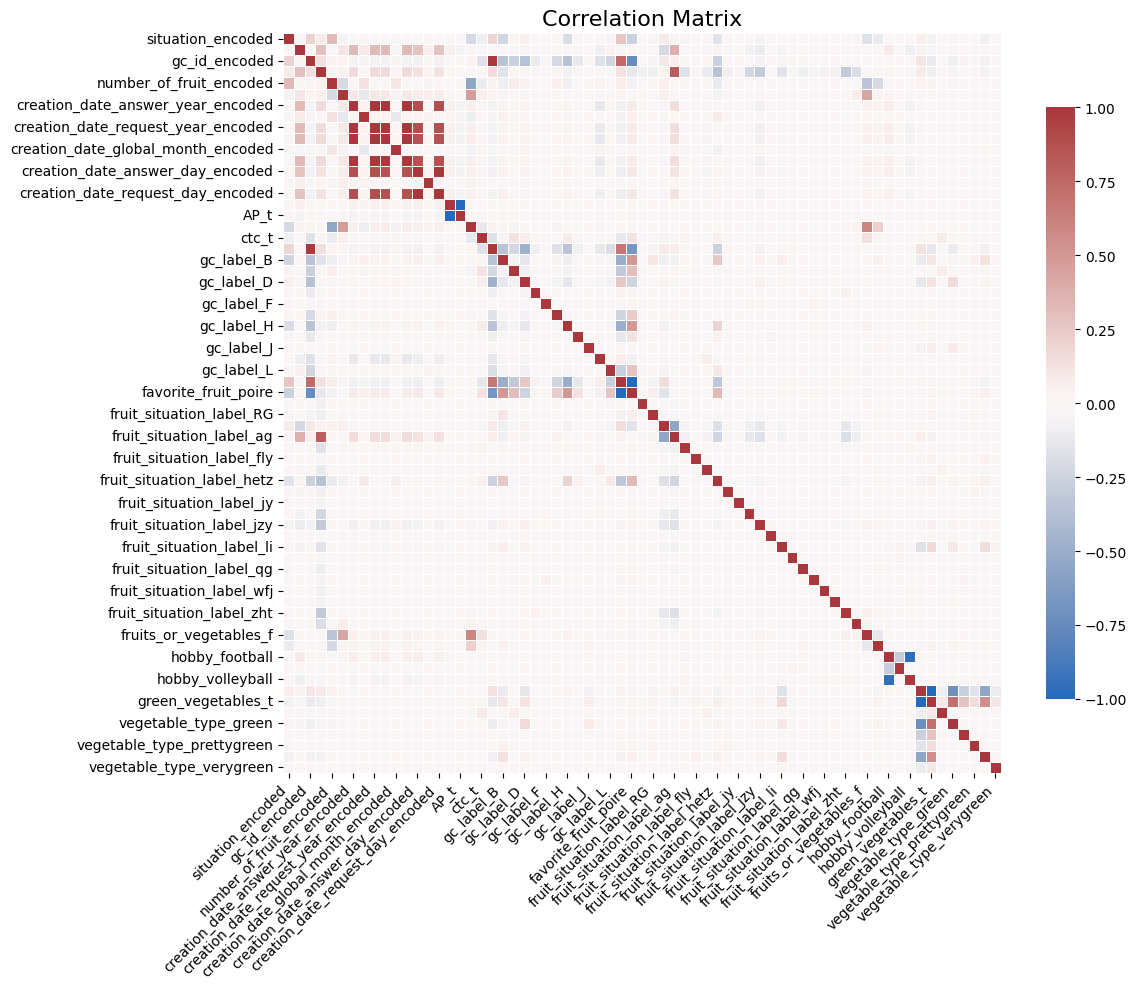

In [17]:
X = df_encoded_train.drop(columns=['target','id'])
correlation_matrix = X.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=False,               
    cmap='vlag',               
    fmt='.2f',                
    linewidths=0.5,            
    cbar_kws={'shrink': 0.8},  
    annot_kws={"size": 8}      
)
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(fontsize=10, rotation=45, ha='right')  
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

1.  **Correlation Among Date-Encoded Features**:
    
    *   Columns like creation\_date\_answer\_year\_encoded, creation\_date\_global\_year\_encoded, and creation\_date\_request\_year\_encoded are likely to be highly correlated because they represent similar temporal data (e.g., years, months, or days).
        
    *   This high correlation is expected because these features are derived from the same or similar dates. If they don't provide additional value to the model, you might consider dropping some of them to reduce redundancy.
        
2.  **Correlation Among Fruit-Related Features**:
    
    *   Features like fruit\_situation\_label\_\* and favorite\_fruit\_\* likely have significant correlations. This is logical as they pertain to similar or overlapping aspects of the dataset (fruit preferences or situations).
        
    *   High correlation within this group indicates that these features describe the same or closely related information.
        
3.  **Correlation Among Vegetable-Related Features**:
    
    *   Features like green\_vegetables\_\* and vegetable\_type\_\* are likely correlated because they are part of the same category (vegetables) and could represent similar patterns in the data.
        
    *   Again, this high correlation is expected, but excessive redundancy might affect model performance. Grouping or selecting representative features can help.
        
4.  **Low Correlation Between Different Categories**:
    
    *   Features from entirely different domains, such as hobby\_\* and vegetable\_type\_\*, or gc\_label\_\* and creation\_date\_\*, are likely to show weak or no correlation. This makes sense, as they describe unrelated aspects of the dataset.

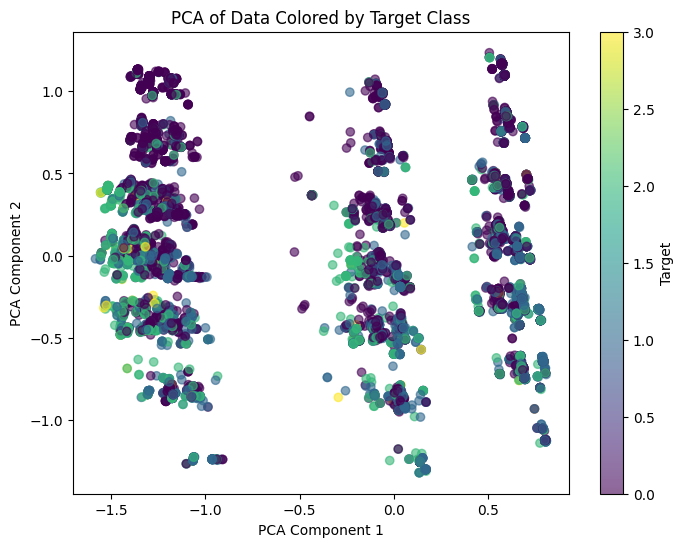

In [16]:
X = df_encoded_train.drop(columns=['target','id'])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_encoded_train['target'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Data Colored by Target Class')
plt.colorbar(label='Target')
plt.show()

**Observations**

*   **Clusters in the PCA Plot:**
    
    *   The 2D PCA visualization shows three distinct clusters, suggesting that the dataset’s features naturally form groups or patterns, meaning that the classes are separable. There are underlying relationships or structures among the features in the data.
        
    *   Since PCA doesn't use the target labels directly to create these clusters, these groupings reflect inherent structures in the data based on the features alone.
        
    *   The clusters are clearly divided by specific colors, it indicates that the PCA components are capturing the variance related to the target variable.

    *   The three visible clusters could be reflecting similar characteristics or properties among the instances, which might correspond to specific classes or groups.
                

**Interpretations**
        
*   **Class Separation:**
    
    *   When certain classes are predominantly in specific clusters, it suggests that the features I’m using are effective at distinguishing those classes, they are informative enough.
        
*   **Feature Redundancy:**
    
    *   Since PCA focuses on the most important directions of variance in the data, the fact that I can reduce the dataset to two components and still preserve much of its structure implies that many of the original features could be redundant or not as impactful.
    
    **Model Implications:**
    
    *   The clear clustering suggests that classification models, such as decision trees, could work well.

#############################################################################################################################################

#### **Data Splitting**

*   **Training Set**: 60% of the original dataset.
    
*   **Validation Set**: 20%.
    
*   **Test Set**: 20%.
    

#### **Models Used**

1.  Logistic Regression
    
2.  Random Forest
    
3.  Gradient Boosting
    
4.  K Nearest Neighbors
    
5.  Extra Trees
    
6.  AdaBoost
    
7.  XGBoost (with **Optuna** for hyperparameter tuning due to compatibility issues with scikit-learn).

I tuned parameters of each model with cross validation.
I kept for each model the optimal set of parameters.

    

#### **Evaluation Metrics**

Each model was evaluated using:

*   Weighted Log-Loss for train, validation, and test sets. (The model with the weakest log loss has been selected)
    
*   Accuracy for train, validation, and test sets.   (Only for information)
    

#### **Predictions**

*   Saved in a directory named **predictions**:
    
    *   **all-1**: Contains predictions from all models except the best-performing one.
        
    *   **best\_predictions**: Contains predictions from the model with the best performance.
        

#### **Format of Predictions**

Each file includes:

*   id: Identifier for the sample.
    
*   class 0, class 1, class 2, class 3: Probabilities of each class.

logreg Train Log-Loss: 2.1427
logreg Validation Log-Loss: 2.2518
logreg Test Log-Loss: 2.2675
logreg Train Accuracy: 68.37%
logreg Validation Accuracy: 68.36%
logreg Test Accuracy: 66.00%


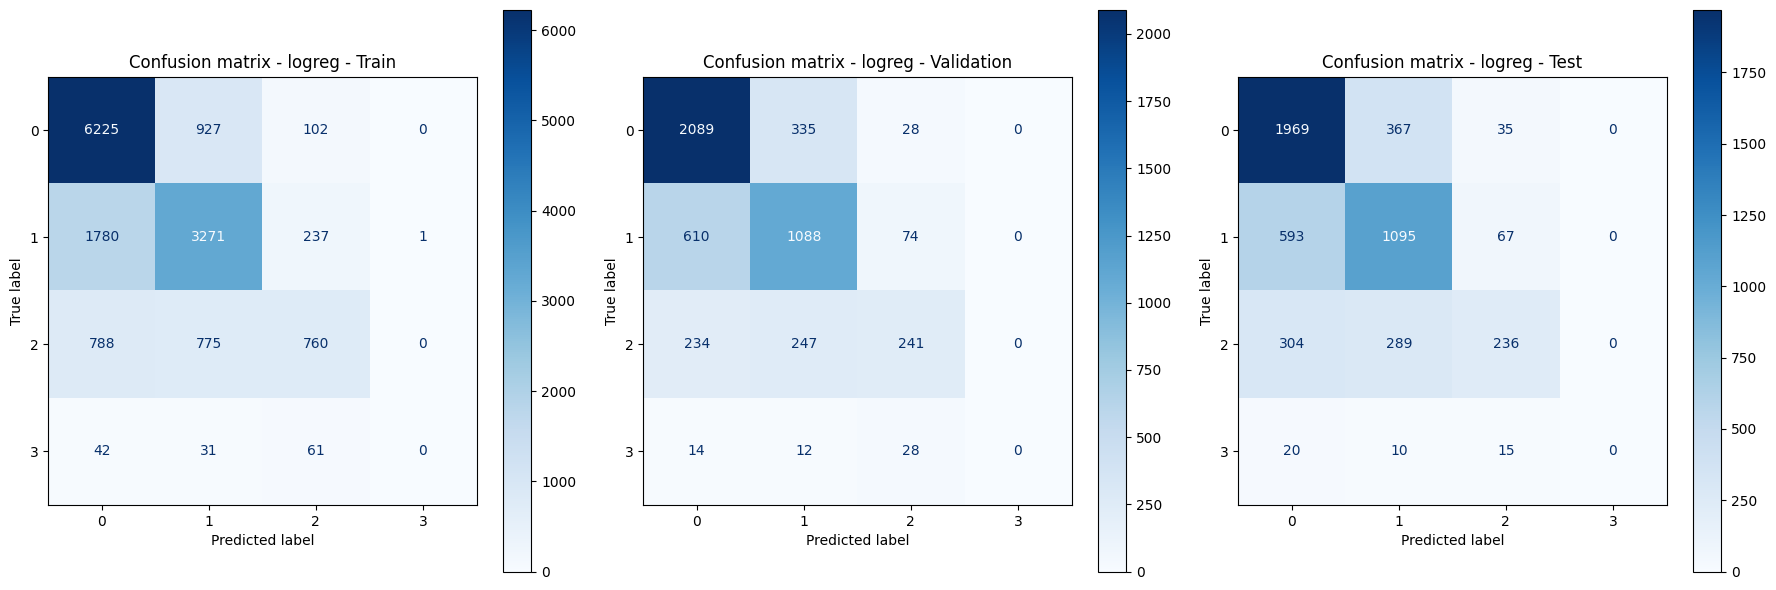

rf Train Log-Loss: 0.8183
rf Validation Log-Loss: 2.9771
rf Test Log-Loss: 2.5276
rf Train Accuracy: 84.42%
rf Validation Accuracy: 69.76%
rf Test Accuracy: 67.32%


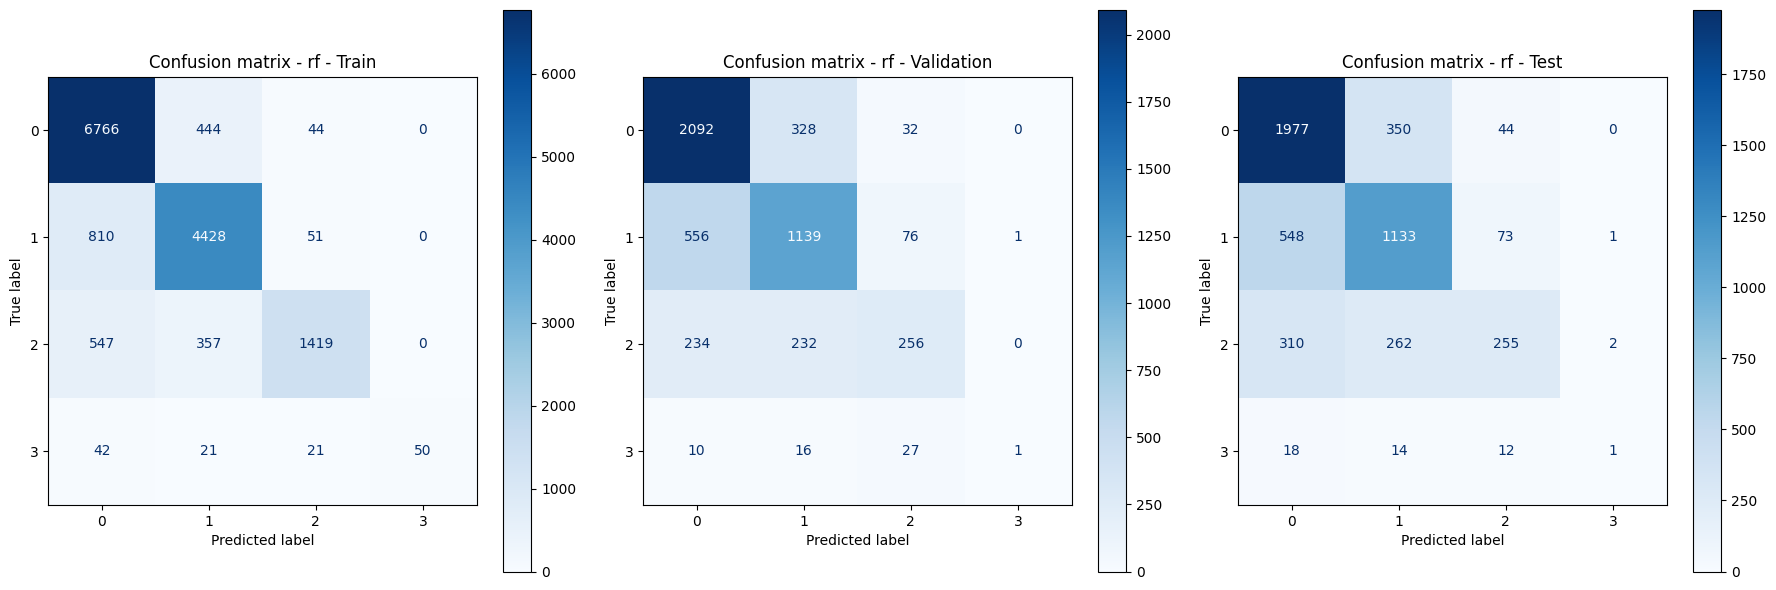

gb Train Log-Loss: 0.8020
gb Validation Log-Loss: 2.1679
gb Test Log-Loss: 2.2064
gb Train Accuracy: 77.23%
gb Validation Accuracy: 71.56%
gb Test Accuracy: 69.30%


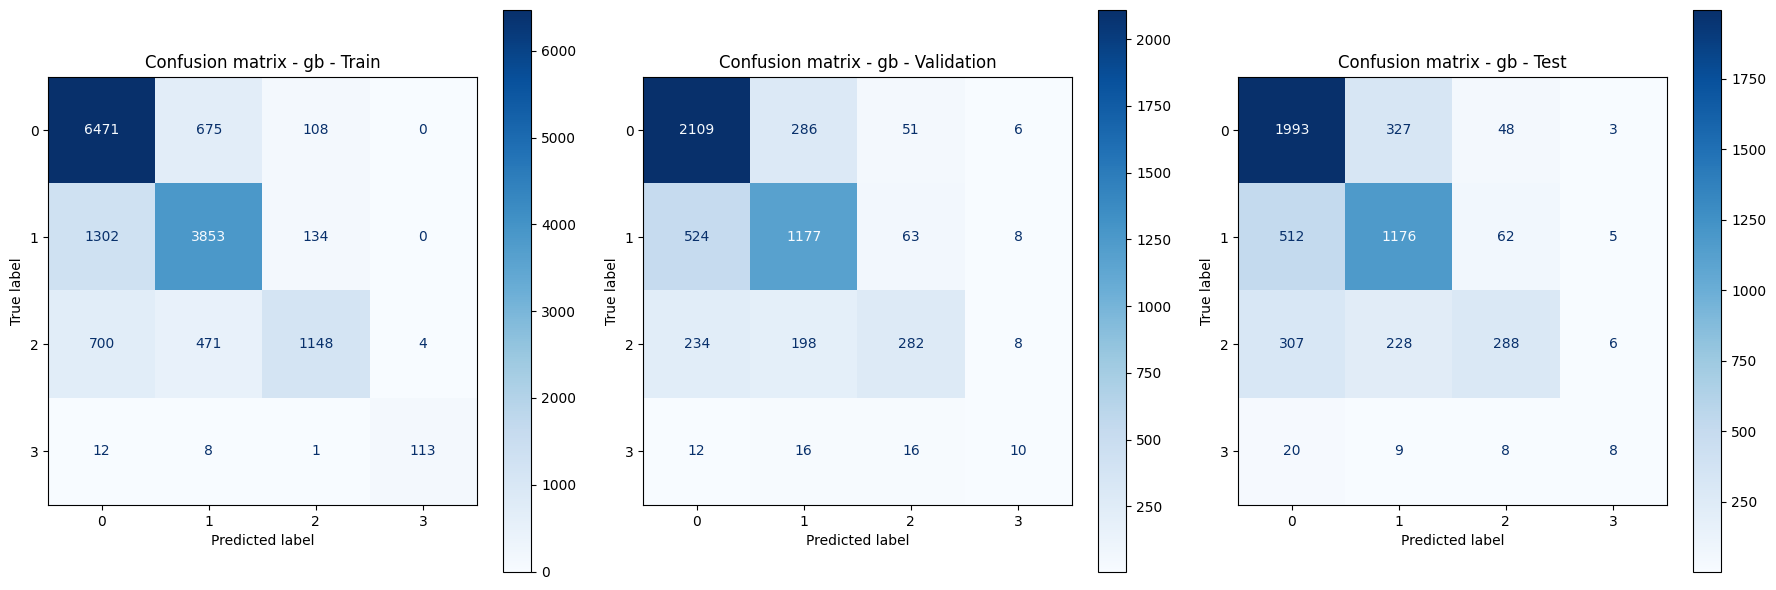

knn Train Log-Loss: 1.1892
knn Validation Log-Loss: 14.3816
knn Test Log-Loss: 14.0579
knn Train Accuracy: 72.51%
knn Validation Accuracy: 66.46%
knn Test Accuracy: 64.28%


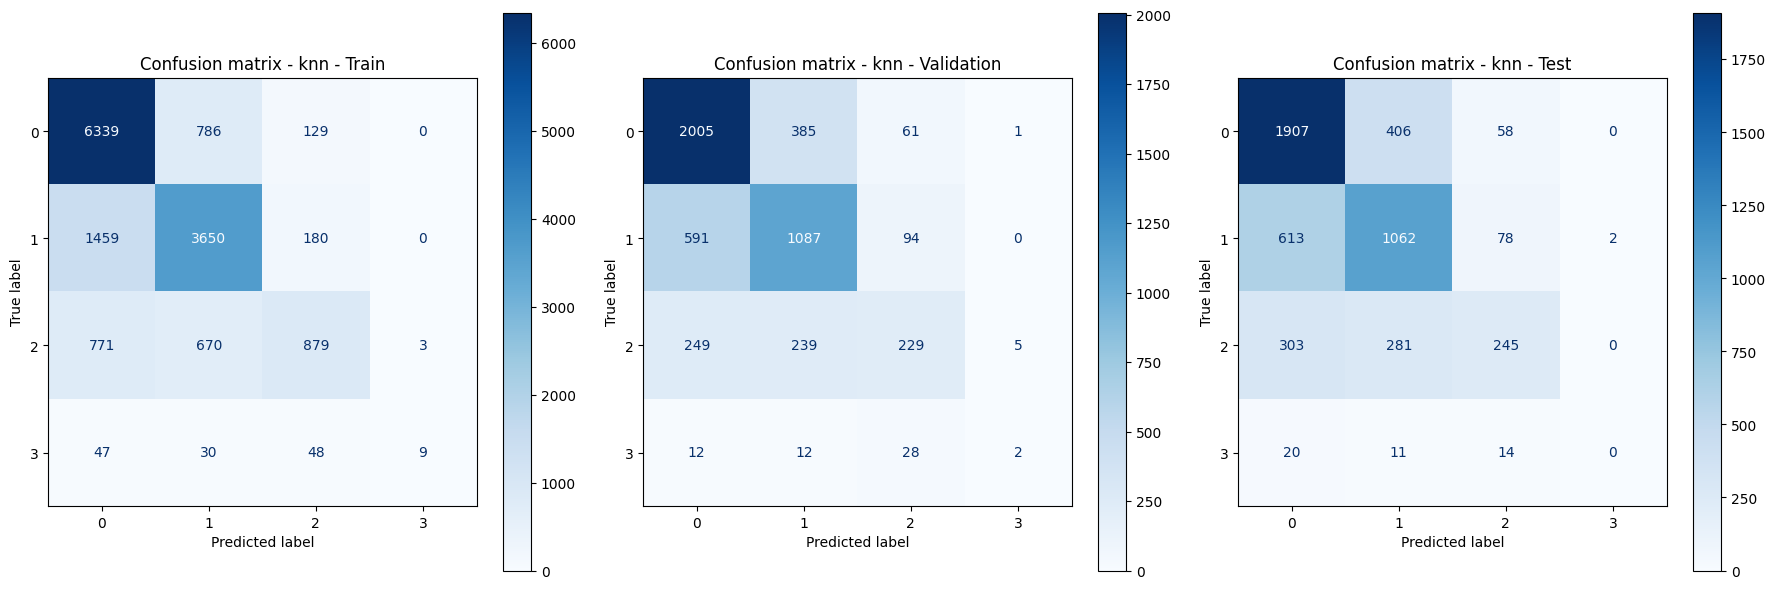

et Train Log-Loss: 1.1629
et Validation Log-Loss: 2.1980
et Test Log-Loss: 2.1759
et Train Accuracy: 74.80%
et Validation Accuracy: 69.34%
et Test Accuracy: 66.82%


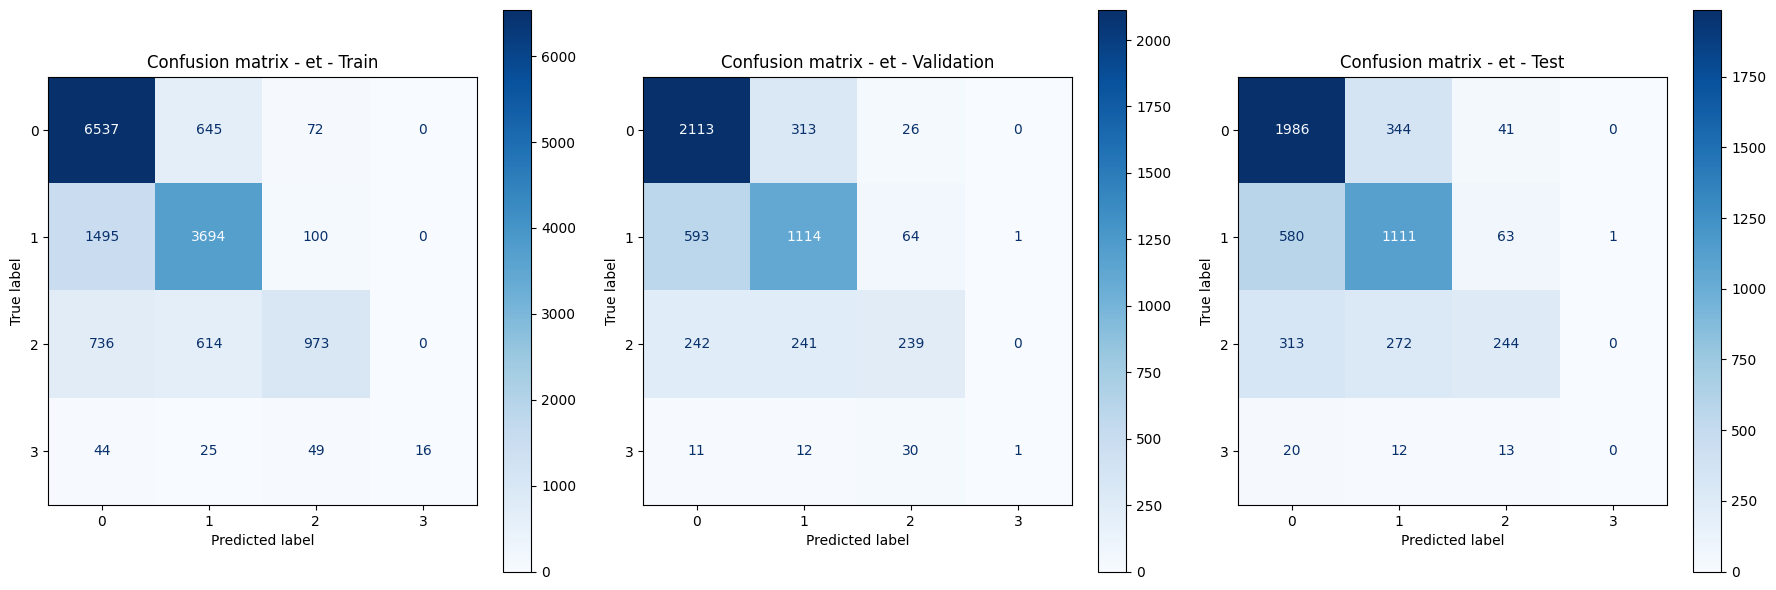

ada Train Log-Loss: 1.4129
ada Validation Log-Loss: 1.4181
ada Test Log-Loss: 1.4169
ada Train Accuracy: 67.23%
ada Validation Accuracy: 66.96%
ada Test Accuracy: 64.86%


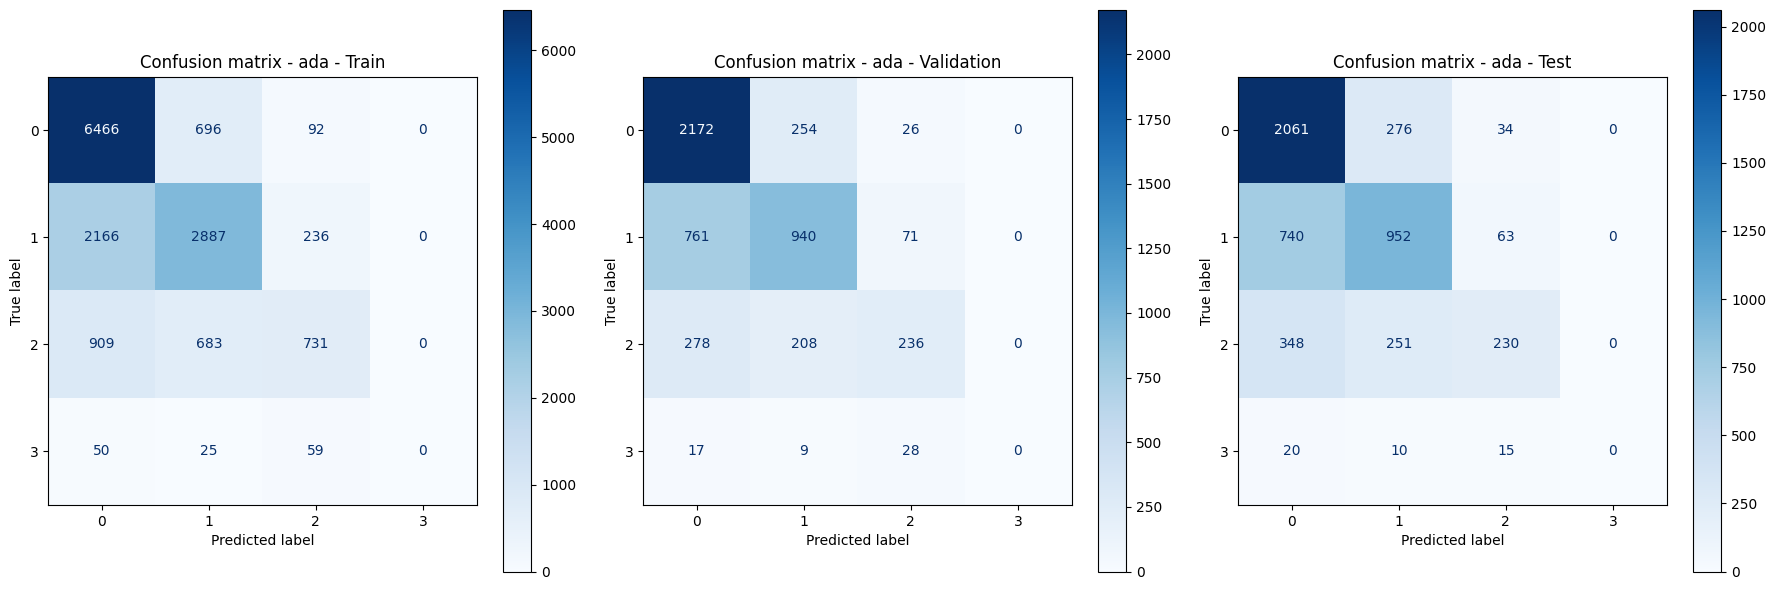

[I 2024-12-29 11:54:11,495] A new study created in memory with name: no-name-24ef898c-97d3-46e3-95a2-fd6d6fc0170c
[I 2024-12-29 11:54:18,611] Trial 0 finished with value: 0.7151868774482071 and parameters: {'max_depth': 10, 'learning_rate': 0.10319991500058312, 'n_estimators': 193, 'subsample': 0.9640395020559214, 'colsample_bytree': 0.973216372611168}. Best is trial 0 with value: 0.7151868774482071.
[I 2024-12-29 11:54:21,434] Trial 1 finished with value: 0.6973448839834893 and parameters: {'max_depth': 4, 'learning_rate': 0.11720770909234399, 'n_estimators': 191, 'subsample': 0.9299078864275776, 'colsample_bytree': 0.8073785348305894}. Best is trial 1 with value: 0.6973448839834893.
[I 2024-12-29 11:54:23,061] Trial 2 finished with value: 0.7326097353515976 and parameters: {'max_depth': 3, 'learning_rate': 0.09341938445761161, 'n_estimators': 160, 'subsample': 0.9597617199125652, 'colsample_bytree': 0.8935462558384358}. Best is trial 1 with value: 0.6973448839834893.
[I 2024-12-29 11

xgb Train Log-Loss: 0.7269
xgb Validation Log-Loss: 1.8972
xgb Test Log-Loss: 1.8810
xgb Train Accuracy: 81.53%
xgb Validation Accuracy: 71.86%
xgb Test Accuracy: 69.88%


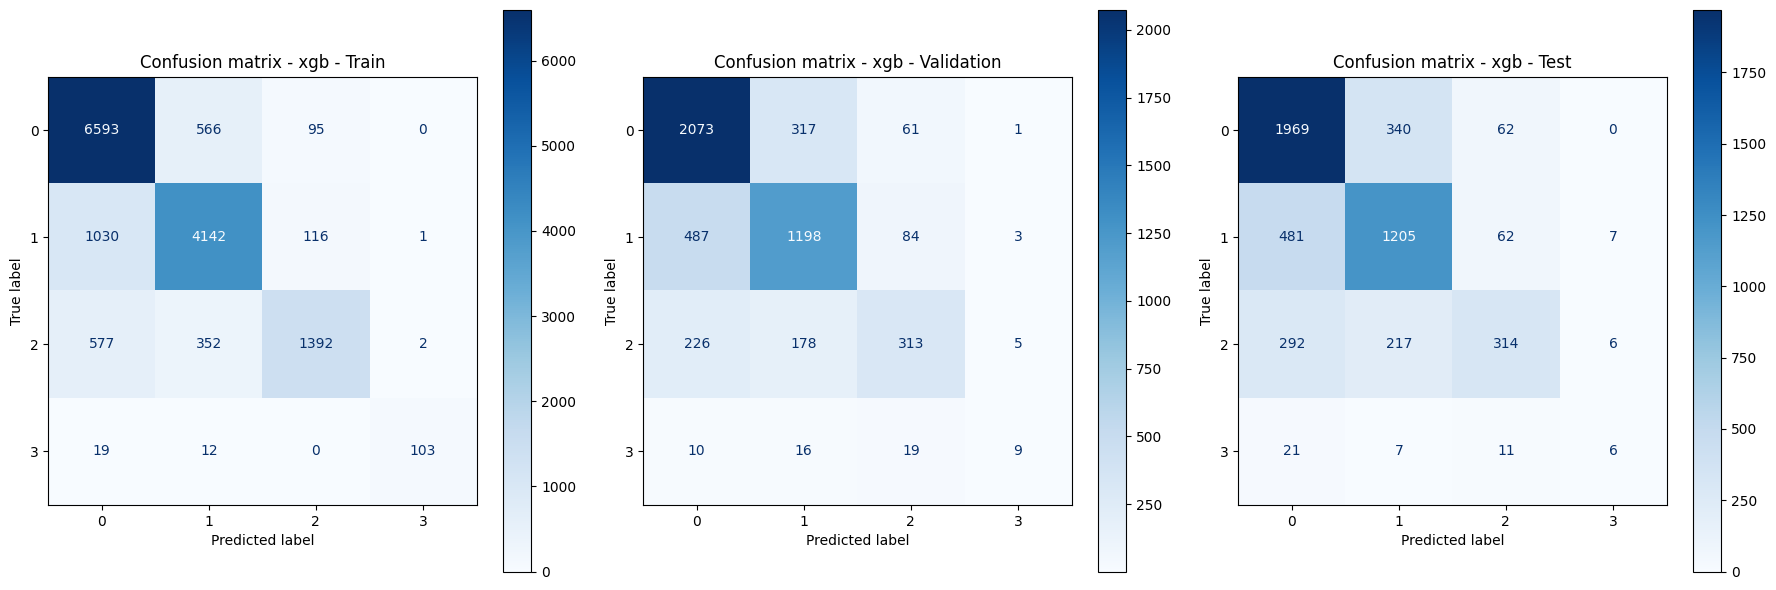

In [7]:
def prepare_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Prepares the data by separating the features (X) and target (y).
    """
    X = df.drop(columns=['target', 'id']).copy()  
    y = df['target'].copy()
    return X, y

def split_data(X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
    """
    Splits the data into training, validation, and test sets.
    """
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

def objective(trial: optuna.Trial, X_train: pd.DataFrame, y_train: pd.Series, X_val: pd.DataFrame, y_val: pd.Series) -> float:
    """
    Objective function for Optuna to optimize XGBoost hyperparameters.
    """
    model = XGBClassifier(
        objective='multi:softprob',
        num_class=len(y_train.unique()),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.2),
        n_estimators=trial.suggest_int('n_estimators', 50, 200),
        subsample=trial.suggest_float('subsample', 0.8, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.8, 1.0),
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred_val = model.predict_proba(X_val)
    return log_loss(y_val, y_pred_val)

def tune_xgb_with_optuna(X_train: pd.DataFrame, y_train: pd.Series, X_val: pd.DataFrame, y_val: pd.Series) -> Tuple[XGBClassifier, Dict[str, any]]:
    """
    Tunes hyperparameters of the XGBoost model using Optuna.
    """
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=50)

    best_params = study.best_trial.params
    best_model = XGBClassifier(
        objective='multi:softprob',
        num_class=len(y_train.unique()),
        **best_params,
        random_state=42
    )
    best_model.fit(X_train, y_train, verbose=False)
    return best_model, best_params

def tune_model(X_train: pd.DataFrame, y_train: pd.Series, model_type: str):
    """
    Tunes hyperparameters of different models using GridSearchCV.
    """
    if model_type == "xgb":
        return None
    elif model_type == "logreg":
        model = LogisticRegression(max_iter=1000, random_state=42)
        param_grid = {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'liblinear']
        }
    elif model_type == "rf":
        model = RandomForestClassifier(random_state=42)
        param_grid = {
            'n_estimators': [50, 100],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    elif model_type == "gb":
        model = GradientBoostingClassifier(random_state=42)
        param_grid = {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6],
            'subsample': [0.8, 1.0]
        }
    elif model_type == "knn":
        model = KNeighborsClassifier()
        param_grid = {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    elif model_type == "et":
        model = ExtraTreesClassifier(random_state=42)
        param_grid = {
            'n_estimators': [50, 100],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    elif model_type == "ada":
        model = AdaBoostClassifier(random_state=42)
        param_grid = {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1]
        }
    else:
        raise ValueError("Model type not recognized")

    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

def evaluate_model(model, X_train: pd.DataFrame, X_val: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_val: pd.Series, y_test: pd.Series, model_name: str, weights: Dict[int, float]) -> None:
    """
    Evaluates model performance on train, validation, and test sets.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plot_confusion_matrix_on_axis(y_train, model.predict(X_train), f'Confusion matrix - {model_name} - Train', model.classes_, axes[0])
    plot_confusion_matrix_on_axis(y_val, model.predict(X_val), f'Confusion matrix - {model_name} - Validation', model.classes_, axes[1])
    plot_confusion_matrix_on_axis(y_test, model.predict(X_test), f'Confusion matrix - {model_name} - Test', model.classes_, axes[2])

    log_loss_train = weighted_log_loss(y_train, model.predict_proba(X_train), weights)
    log_loss_val = weighted_log_loss(y_val, model.predict_proba(X_val), weights)
    log_loss_test = weighted_log_loss(y_test, model.predict_proba(X_test), weights)

    accuracy_train = accuracy_score(y_train, model.predict(X_train))
    accuracy_val = accuracy_score(y_val, model.predict(X_val))
    accuracy_test = accuracy_score(y_test, model.predict(X_test))

    print(f"{model_name} Train Log-Loss: {log_loss_train:.4f}")
    print(f"{model_name} Validation Log-Loss: {log_loss_val:.4f}")
    print(f"{model_name} Test Log-Loss: {log_loss_test:.4f}")
    print(f"{model_name} Train Accuracy: {accuracy_train * 100:.2f}%")
    print(f"{model_name} Validation Accuracy: {accuracy_val * 100:.2f}%")
    print(f"{model_name} Test Accuracy: {accuracy_test * 100:.2f}%")

    plt.tight_layout()
    plt.show(block=False)

def plot_confusion_matrix_on_axis(y_true: np.ndarray, y_pred: np.ndarray, title: str, classes: list, ax) -> None:
    """
    Plots a confusion matrix on a given axis.
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(title)

def make_predictions(model, df_encoded_test: pd.DataFrame, encoder, model_name: str) -> str:
    """
    Makes predictions on the test dataset and saves the results.
    """
    ids = df_encoded_test['id']
    df_encoded_test = encoder.transform(df_encoded_test.drop(columns=['id']))

    y_test_pred = model.predict_proba(df_encoded_test)

    output = pd.DataFrame(y_test_pred, columns=[f'class_{i}' for i in range(y_test_pred.shape[1])])
    output['id'] = ids
    output = output[['id'] + [f'class_{i}' for i in range(y_test_pred.shape[1])]]
    
    output_filename = data_dir / f"predictions_{model_name}.csv"
    output.to_csv(output_filename, index=False)
    return output_filename

def encode_data(train_df: pd.DataFrame, test_df: pd.DataFrame, encoder) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Encodes the training and test datasets using the given encoder.
    """
    df_train = train_df.copy()
    df_train.columns = df_train.columns.str.strip()
    df_encoded_train = encoder.fit_transform(df_train)
    
    df_test = test_df.copy()
    df_test.columns = df_test.columns.str.strip()
    df_encoded_test = encoder.transform(df_test)
    
    return df_encoded_train, df_encoded_test

def create_prediction_directories() -> Tuple[str, str]:
    """
    Creates directories for saving the prediction files.
    """
    base_path = data_dir / "predictions"
    all_predictions_path = os.path.join(base_path, "all-1")
    best_predictions_path = os.path.join(base_path, "best_predictions")

    os.makedirs(all_predictions_path, exist_ok=True)
    os.makedirs(best_predictions_path, exist_ok=True)

    return all_predictions_path, best_predictions_path

def move_predictions_to_directories(predictions: Dict[str, str], model_log_losses: Dict[str, float], all_predictions_path: str, best_predictions_path: str) -> None:
    """
    Moves prediction files to the appropriate directories based on the model with the lowest log-loss.
    """
    best_model_name = min(model_log_losses, key=model_log_losses.get)
    best_model_filename = predictions[best_model_name]

    for model_type, prediction_file in predictions.items():
        if model_type == best_model_name:
            os.rename(prediction_file, os.path.join(best_predictions_path, os.path.basename(prediction_file)))
        else:
            os.rename(prediction_file, os.path.join(all_predictions_path, os.path.basename(prediction_file)))

def weighted_log_loss(y_true: np.ndarray, y_pred: np.ndarray, weights: Dict[int, float]) -> float:
    """
    Computes the weighted log-loss.
    """
    sample_weights = np.array([weights[label] for label in y_true])
    return log_loss(y_true, y_pred, sample_weight=sample_weights)

def main(train_df: pd.DataFrame, test_df: pd.DataFrame, encoder, weights: Dict[int, float]) -> None:
    """
    Main pipeline for training and evaluating models, and saving predictions.
    """
    df_encoded_train, df_encoded_test = encode_data(train_df, test_df, encoder)
    
    X, y = prepare_data(df_encoded_train)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

    all_predictions_path, best_predictions_path = create_prediction_directories()

    predictions = {}
    model_log_losses = {}

    model_types = ["logreg", "rf", "gb", "knn", "et", "ada"] 
    for model_type in model_types:
        model = tune_model(X_train, y_train, model_type) 
        evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, model_type, weights)
        log_loss_val = weighted_log_loss(y_val, model.predict_proba(X_val), weights)
        model_log_losses[model_type] = log_loss_val
        pred_filename = make_predictions(model, df_encoded_test, encoder, model_type)
        predictions[model_type] = pred_filename
    
    best_model, best_params = tune_xgb_with_optuna(X_train, y_train, X_val, y_val)
    evaluate_model(best_model, X_train, X_val, X_test, y_train, y_val, y_test, "xgb", weights)
    log_loss_val = weighted_log_loss(y_val, best_model.predict_proba(X_val), weights)
    model_log_losses["xgb"] = log_loss_val
    pred_filename = make_predictions(best_model, df_encoded_test, encoder, "xgb")
    predictions["xgb"] = pred_filename

    move_predictions_to_directories(predictions, model_log_losses, all_predictions_path, best_predictions_path)


    # Call the main function

weights = {0: 1, 1: 10, 2: 100, 3: 1000}

main(train_df, test_df, encoder, weights)

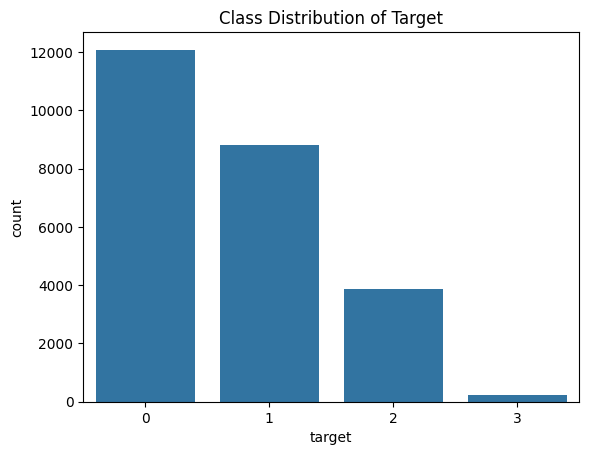

In [4]:
sns.countplot(x='target', data=df_encoded_train)
plt.title('Class Distribution of Target')
plt.show()

The number of samples in each class decreases from class 0 to class 3. The target data is unbalanced. This coincides with my results. The AdaBoost model classifies as follows:

*   **Class 0:** **86.9%**
    
*   **Class 1:** **54.24%**
    
*   **Class 2:** **27.74%**
    
*   **Class 3:** **0%**
    

This is not surprising since class 0 was seen by the model much more frequently, whereas class 3 is less represented. As a result, class 3 was not sufficiently observed during training. This implies that predictions for class 3 are poor.

### AdaBoost:

#### No Erroneous Predictions for Class 3:

In the AdaBoost confusion matrix, there are no predictions for class 3 when the true label is not 3 (the "Pred 3" column is entirely zero).This means AdaBoost completely avoids "risking" predictions for class 3, thereby minimizing the severe penalties associated with the weighted log-loss for such errors.

#### Misclassification of True Class 3:

All true instances of class 3 are misclassified into other classes (primarily class 2 and sometimes class 1).While this does incur a penalty in the log-loss, it is less severe than incorrectly predicting class 3 when it is not the true label. This is because the weights for errors in classes 0, 1, and 2 are much lower compared to class 3 (weight = 1000).

### XGBoost:

#### Errors in Predicting Class 3:

XGBoost makes 11 errors by predicting class 3 when the true label is not 3.These mistakes incur a significant penalty in the weighted log-loss calculation, as they carry a weight of **1000** for misclassifications involving class 3.

#### No Correct Predictions for Class 3:

Like AdaBoost, XGBoost fails to correctly classify any instances of class 3 (the true class 3 samples are distributed across other predicted classes).When combined with the erroneous predictions of class 3, this strongly impacts XGBoost's log-loss score.

### Impact on Weighted Log-Loss:

The **weighted log-loss** applies penalties proportional to the weights of the classes:

*   For a true class 3 misclassified into another class, the penalty is very high (weight = **1000**).
    
*   For an incorrect prediction of class 3 when it is not the true label, the penalty is equally severe (weight = **1000**).
    

#### Comparison:

*   **AdaBoost** avoids incorrect predictions for class 3 entirely, thus limiting its negative contribution to the log-loss.
    
*   **XGBoost**, on the other hand, incurs significant penalties due to its 11 incorrect predictions of class 3, which partially explains its higher log-loss.

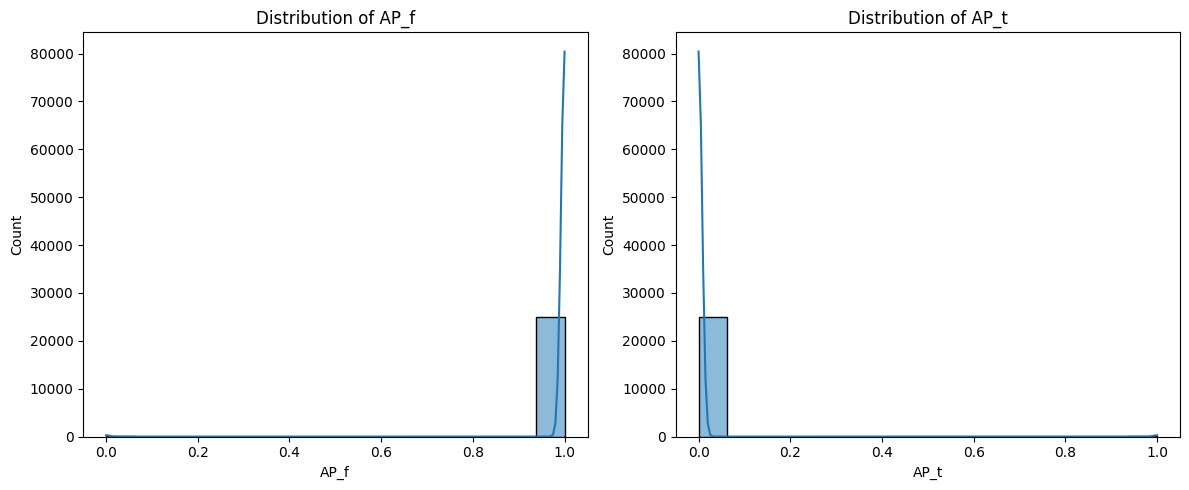

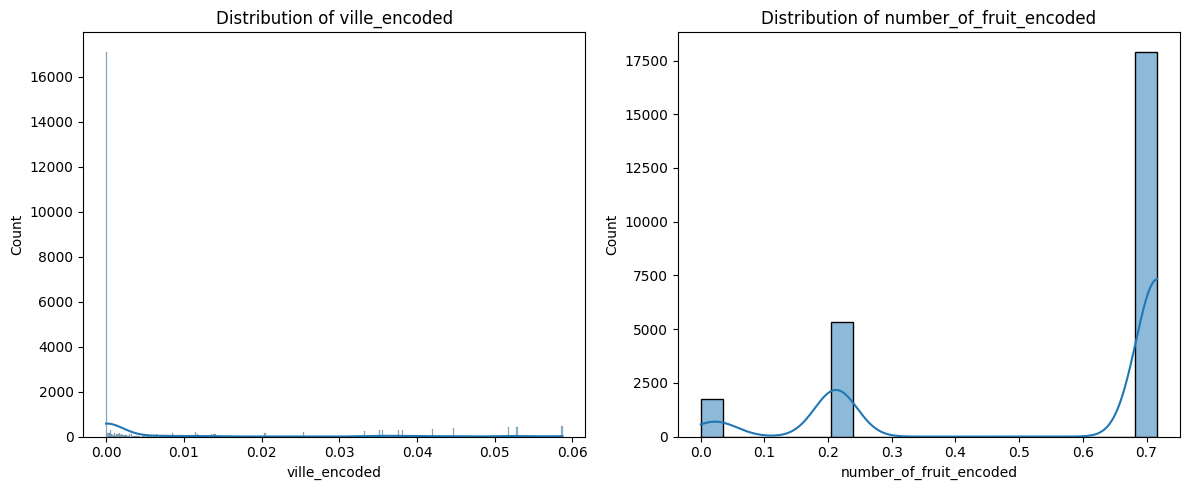

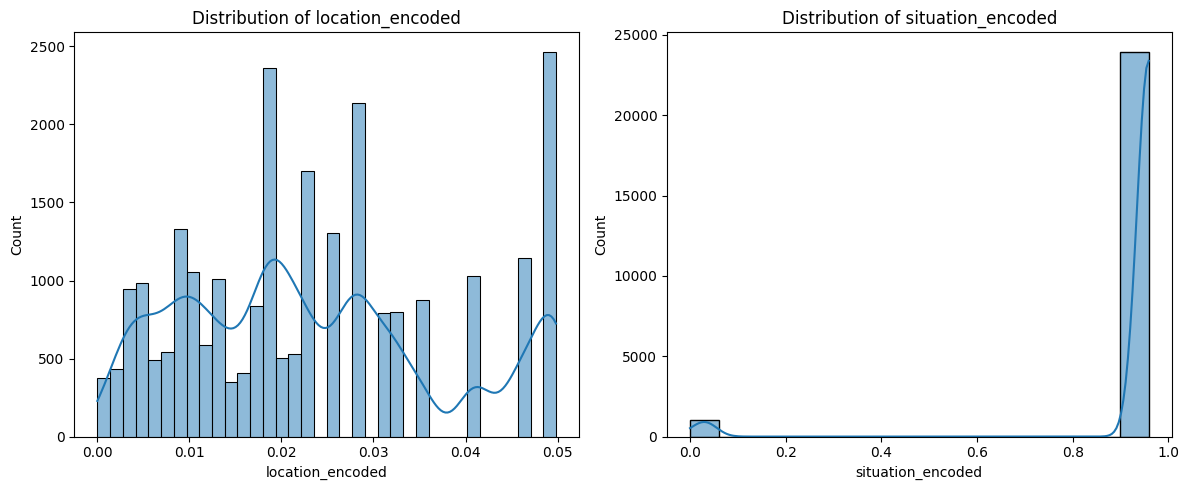

In [18]:
columns = ['AP_f', 'AP_t', 'ville_encoded', 'number_of_fruit_encoded', 'location_encoded', 'situation_encoded']

for i in range(0, len(columns), 2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)
    for ax, col in zip(axes, columns[i:i+2]):  
        sns.histplot(data=df_encoded_train, x=col, kde=True, ax=ax)
        ax.set_title(f'Distribution of {col}', fontsize=12)
    plt.tight_layout()
    plt.show()

### **1\. Unbalanced Categorical Features**

*   **Features: 'AP\_f', 'AP\_t', 'ville\_encoded'**
    
*   **Interpretation:**
    
    *   Unbalanced categorical features indicate that some categories are overrepresented in the dataset, while others are underrepresented.
        
    *   For example, 'ville\_encoded' (representing different cities) might have most samples coming from a few major cities, with only a small number from less populous cities.
        
    *   Similarly, 'AP\_f' and 'AP\_t' may represent categories with skewed distributions, such as one dominant class and a few minority classes.
        
*   **Impact on Model:**
    
    *   Models might become biased toward the majority classes and fail to adequately capture patterns for minority classes.
        
    *   For instance, a decision tree may disproportionately split on features with dominant categories, while ensemble methods may fail to generalize well for rare categories.
        
*   **Mitigation Strategies:**
    
    *   **Oversampling/Undersampling:** Increase the representation of underrepresented categories or downsample the dominant ones.
        
    *   **Class Weights:** Assign higher importance (weights) to minority classes during training to counteract imbalance.
        
    *   **Feature Transformation:** Consider merging rare categories into "Other" or re-encoding categorical variables using techniques like target encoding or embeddings.
        

### **2\. Balanced Quantitative Features**

*   **Features: 'location\_encoded'**
    
*   **Interpretation:**
    
    *   Balanced quantitative features have values that are uniformly distributed or approximately evenly represented across the dataset.
        
    *   'location\_encoded' might reflect a geographical feature that is spread evenly across the dataset (e.g., locations representing diverse but evenly sampled regions).
        
*   **Impact on Model:**
    
    *   Balanced features ensure that the model has sufficient data to learn patterns across the range of values.
        
    *   This reduces the risk of the model focusing too heavily on one subset of the feature's range.
        

### **3\. Unbalanced Quantitative Features**

*   **Features: 'situation\_encoded', 'number\_of\_fruit\_encoded'**
    
*   **Interpretation:**
    
    *   For example situation\_encoded' might represent socioeconomic status with most samples concentrated in middle-income levels and very few in high or low-income brackets.
        
    *   Similarly, 'number\_of\_fruit\_encoded' could reflect an inventory count where a few records show very high counts while most are low or zero.
        
*   **Impact on Model:**
    
    *   Skewed features can cause models to underperform because they may focus on the dominant range of values and ignore or poorly generalize to the minority range.
        
    *   For tree-based models, this could lead to splits that don't account for rare but potentially important values. For linear models, this may result in poor fit due to the unequal influence of extreme values.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [19:13:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


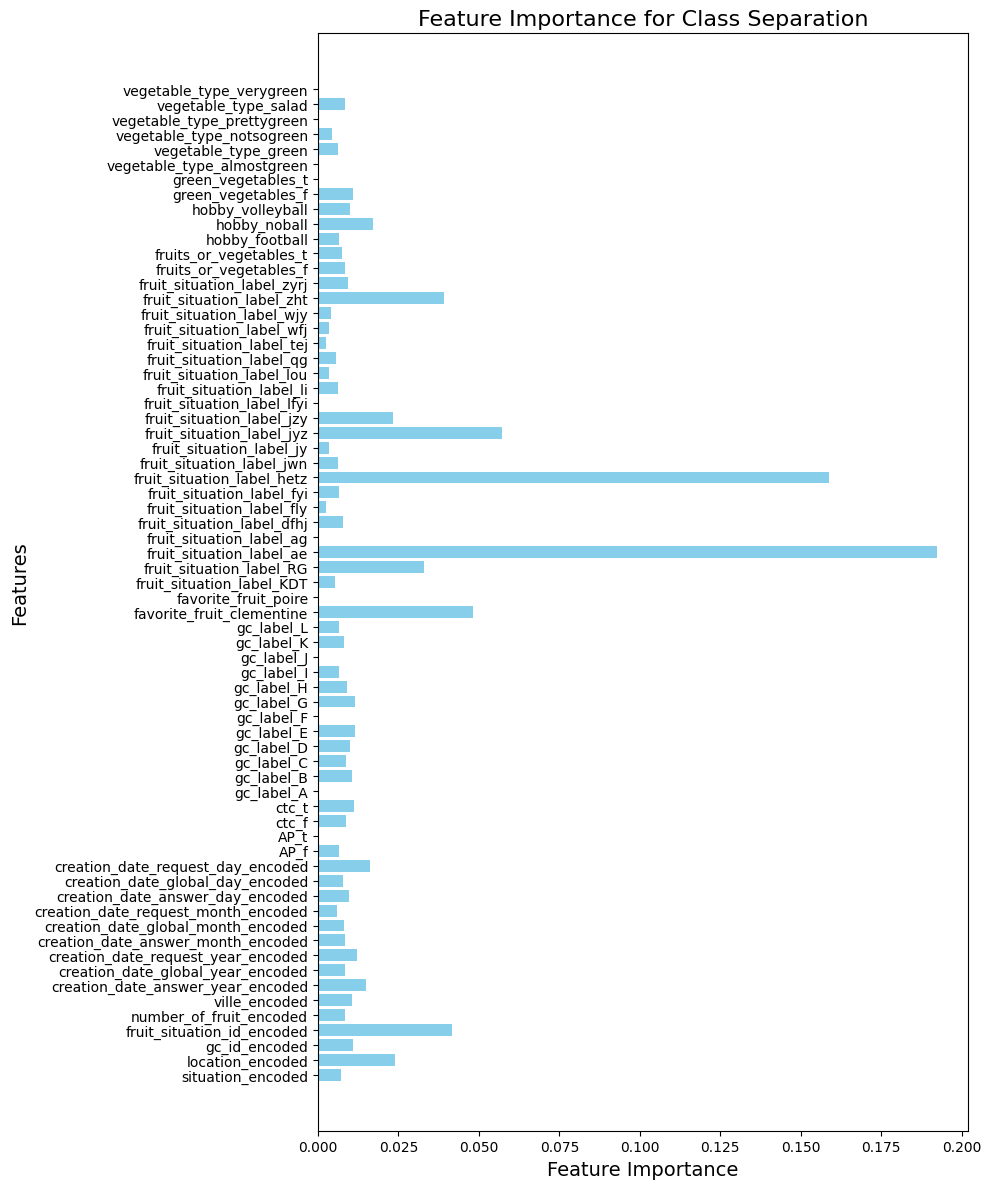

In [19]:
def prepare_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Prepares the data by separating the features (X) and target (y).
    """
    X = df.drop(columns=['target', 'id']).copy()  
    y = df['target'].copy()
    return X, y

def split_data(X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
    """
    Splits the data into training, validation, and test sets.
    """
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test


X, y = prepare_data(df_encoded_train)


X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  
model.fit(X_train, y_train)

importances = model.feature_importances_

plt.figure(figsize=(10, 12))
plt.barh(X_train.columns, importances, color='skyblue')
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Importance for Class Separation', fontsize=16)
plt.yticks(fontsize=10)  
plt.tight_layout()  
plt.show()

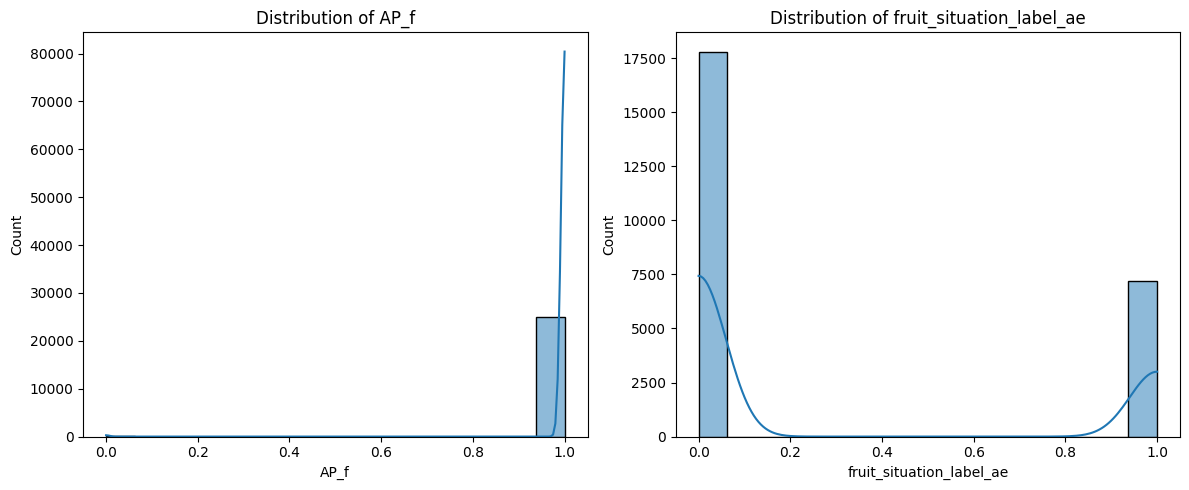

In [ ]:
columns = ['AP_f', 'fruit_situation_label_ae']

fig, axes = plt.subplots(1, len(columns), figsize=(12, 5), sharey=False)

for ax, col in zip(axes, columns):
    sns.histplot(data=df_encoded_train, x=col, kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}', fontsize=12)

plt.tight_layout()
plt.show()


**Balanced vs. Unbalanced Features**:

*   **fruit\_situation\_label\_ae** is a balanced feature, meaning its values are spread more evenly across different categories or groups. This allows the model to distinguish between different classes based on this feature, and as a result, it contributes significantly to the prediction, leading to a higher feature importance.
    
*   **AP\_f**, on the other hand, is unbalanced. If the feature always has the same value (or a very limited range of values), it doesn't provide much discriminatory power. In this case, regardless of the target class, the model would not learn anything useful from this feature, and its importance will be low.

#############################################################################################################################################

### Further Development

*   **Increase the Number of Optimization Steps**: Currently, the hyperparameter tuning process using Optuna has a limited number of trials (50). Increasing this number would provide a deeper exploration of the hyperparameter space and might lead to a better combination of parameters, further improving the model's performance.
    
*   **Use a More Powerful Optimizer**: Although Optuna is a powerful optimization tool, exploring other advanced optimizers like
    
    ADAM could potentially improve the model by using more sophisticated strategies to search the hyperparameter space. These methods could help avoid local minima and better explore the global optimum.
    

*   **Other models**: Other models could be tied as SVMs, or neural networks.

**Next Steps**

*   **Investigate Overlapping Clusters:**  If there are clusters with overlapping classes, I could try engineering new features to improve separation or explore non-linear dimensionality reduction methods, like t-SNE, to better visualize and separate the data.
        
*   **Feature Reduction:** If the PCA components show good separation, I could use the reduced dimensions for faster model training and testing, improving both efficiency and performance.
    
*    **Feature Engineering**: Exploring additional feature engineering techniques (e.g., interaction features or polynomial features) could help capture more complex patterns in the data, improving model performance.
